# Comparison of real HPL executions

In [1]:
import io
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['index'] = range(len(result))
    return result

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

old_execution = [
    'grenoble_2018-10-10_1811810.zip',
    'grenoble_2018-10-10_1811847.zip',
]
new_execution = [
    'grenoble_2019-03-15_1855885.zip'
]
new_execution_fixed = [
    'grenoble_2019-03-18_1856059.zip'
]
dfold = pandas.concat([read_result(f) for f in old_execution])
dfnew = pandas.concat([read_result(f) for f in new_execution])
dfnewfixed = pandas.concat([read_result(f) for f in new_execution_fixed])
dfold['mode'] = 'old'
dfnew['mode'] = 'new'
dfnewfixed['mode'] = 'new:old_env'
df = pandas.concat([dfold, dfnew, dfnewfixed])
sizes = set(dfold.matrix_size) & set(dfnew.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,bcast,block_size,depth,gflops,index,matrix_size,mem_align,mode,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,17540.0,0,75000,8,old,1,32,32,32,0.000928,2,0,1,16.03
1,2,128,1,23290.0,1,225000,8,old,1,32,32,32,0.000612,2,0,1,326.05
2,2,128,1,22260.0,2,175000,8,old,1,32,32,32,0.000827,2,0,1,160.53
3,2,128,1,20990.0,3,125000,8,old,1,32,32,32,0.000793,2,0,1,62.02
4,2,128,1,23630.0,4,250000,8,old,1,32,32,32,0.000563,2,0,1,440.78


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'mode', 'index'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,mem_align,swap,depth,thread_per_process,rfact,pfact,block_size,proc_q,bcast,proc_p,process_per_node
0,8,0,1,1,2,1,128,32,2,32,32


### Checking the OS version

In [3]:
for version_name in ['version', 'gcc', 'mpi', 'kernel', 'cpu']:
    for exp in [old_execution, new_execution, new_execution_fixed]:
        versions = set()
        for filename in exp:
            info = get_yaml(filename, 'info.yaml')
            hostnames = [key for key in info.keys() if key.startswith('dahu')]
            versions.update([info[h][version_name] for h in hostnames])
        assert len(versions) == 1
        print(versions.pop())
    print()

Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.144-3.1 (2019-02-19)
Linux version 4.9.0-8-amd64 (debian-kernel@lists.debian.org) (gcc version 6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u4 (2018-08-21)

6.3.0
6.3.0
6.3.0

mpirun (Open MPI) 2.0.2
mpirun (Open MPI) 2.0.2
mpirun (Open MPI) 2.0.2

4.9.0-8-amd64
4.9.0-8-amd64
4.9.0-8-amd64

Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz



### Comparing the executions

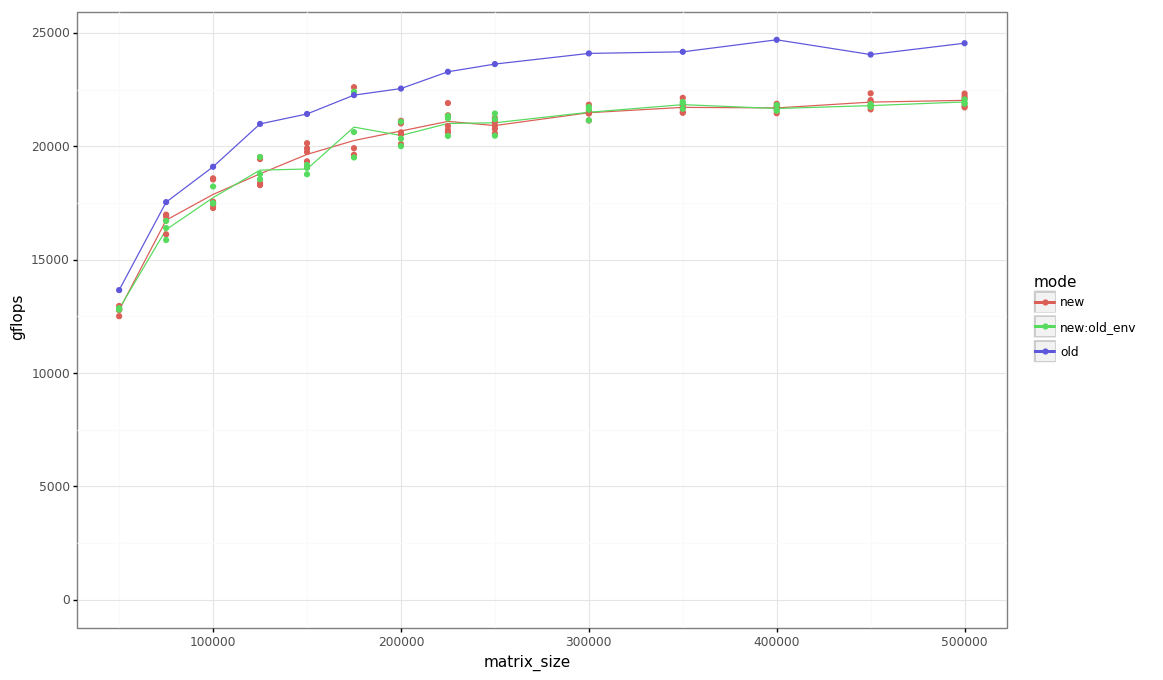

<ggplot: (8792469178751)>

In [4]:
import numpy

ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

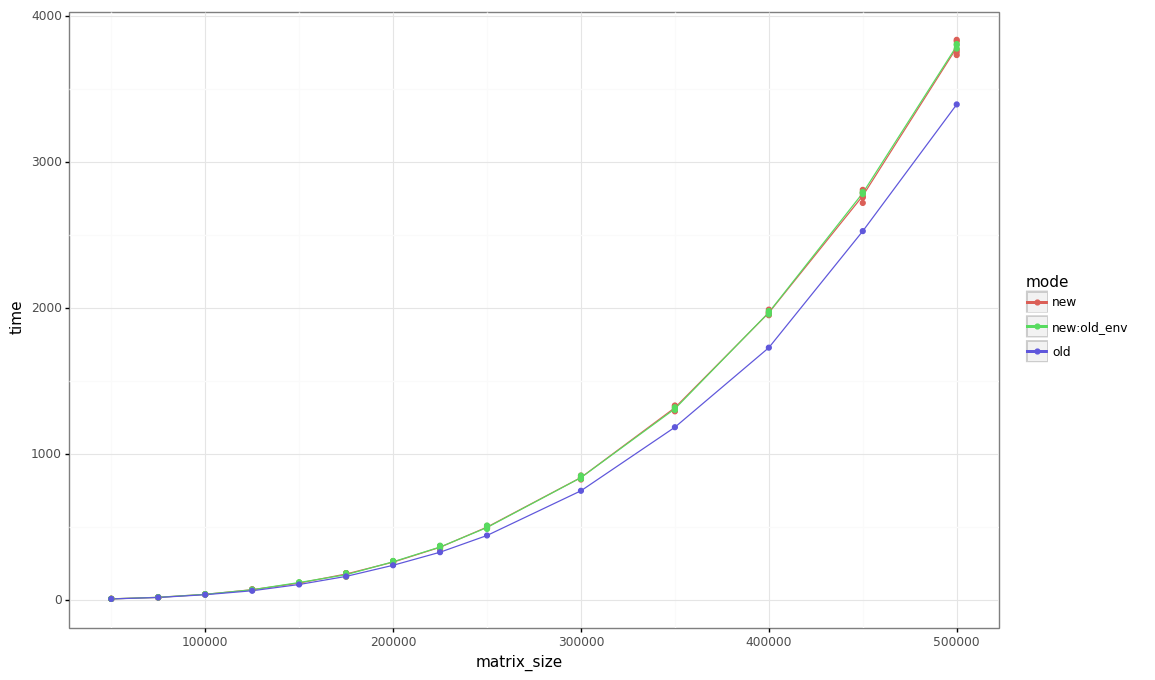

<ggplot: (8792444432143)>

In [5]:
ggplot(df, aes(x='matrix_size', y='time', color='mode')) + stat_summary(fun_y = numpy.mean, geom='line') + geom_point() + theme_bw() + expand_limits(y=0)

### What is this weird outlier in the new executions?

In [6]:
tmp = df[df.matrix_size == 175000]
tmp[['gflops', 'time', 'mode', 'index']]

,gflops,time,mode,index
2,22260.0,160.53,old,2
0,22610.0,158.00,new,0
18,19540.0,182.81,new,18
41,19590.0,182.43,new,41
54,19630.0,182.04,new,54
58,19920.0,179.37,new,58
0,22410.0,159.44,new:old_env,0
18,20630.0,173.20,new:old_env,18
41,19510.0,183.12,new:old_env,41


### Maximum performance

In [7]:
dfold[dfold.gflops == dfold.gflops.max()]

,bcast,block_size,depth,gflops,index,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time,mode
2,2,128,1,24700.0,2,400000,8,1,32,32,32,0.000531,2,0,1,1727.64,old


In [8]:
dfnew[dfnew.gflops == dfnew.gflops.max()]

,mem_align,process_per_node,time,block_size,matrix_size,residual,gflops,proc_q,pfact,rfact,depth,swap,thread_per_process,proc_p,bcast,index,mode
0,8,32,158.0,128,175000,0.000827,22610.0,32,1,2,1,0,1,32,2,0,new


### Regression

In [9]:
import statsmodels.formula.api as st

for df in [dfold, dfnew, dfnewfixed]:
    df['N3'] = df['matrix_size'] ** 3
    df['N2'] = df['matrix_size'] ** 2
    reg = st.ols(data=df, formula='time ~ N3+N2').fit()
    p = reg.params
    df['pred_time'] = p.Intercept + df.N2*p.N2 + df.N3*p.N3
    df['nb_flops'] = (2/3*df.N3 + 2*df.N2) * 1e-9
    df['pred_gflops'] = df['nb_flops'] / df['pred_time']
    c = reg.conf_int()
    df['pred_time_min'] = c[0].Intercept + df.N2*c[0].N2 + df.N3*c[0].N3
    df['pred_time_max'] = c[1].Intercept + df.N2*c[1].N2 + df.N3*c[1].N3
    df['pred_gflops_min'] = df['nb_flops'] / df['pred_time_max']
    df['pred_gflops_max'] = df['nb_flops'] / df['pred_time_min']

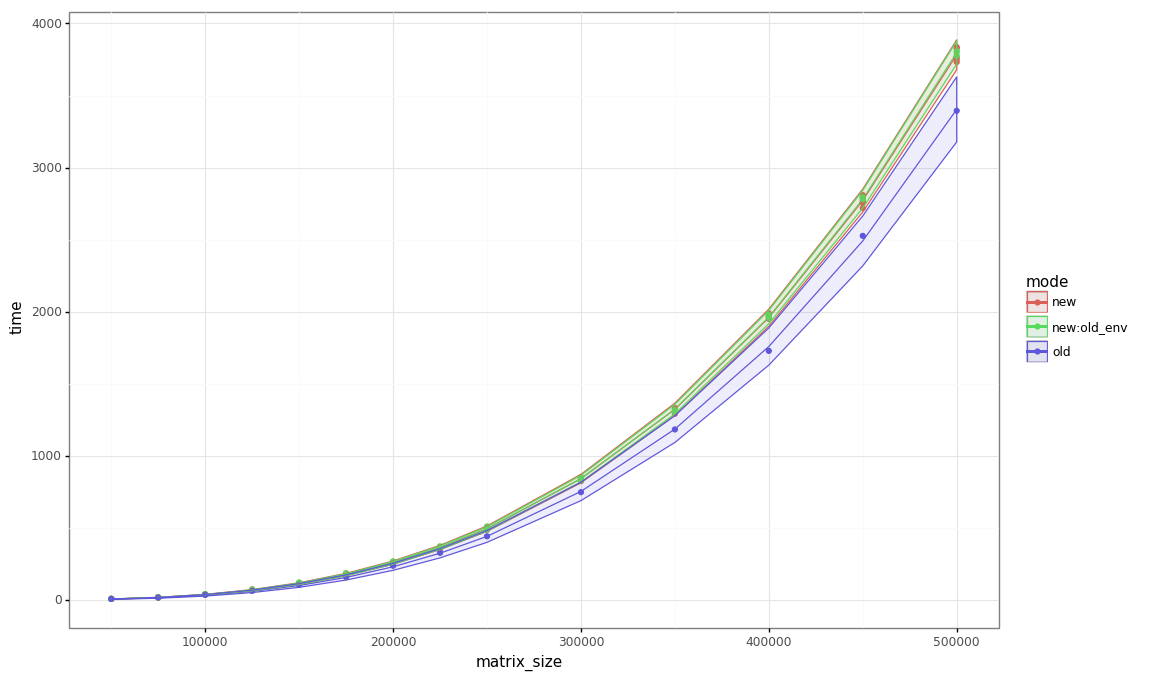

<ggplot: (8792400037398)>

In [10]:
df = pandas.concat([dfold, dfnew, dfnewfixed])
plot = ggplot(df, aes(x='matrix_size', y='time', color='mode')) + geom_line(aes(x='matrix_size', y='pred_time')) + geom_point() + theme_bw() + expand_limits(y=0)
plot + geom_ribbon(aes(ymin='pred_time_min', ymax='pred_time_max', fill='mode'), alpha=0.1)

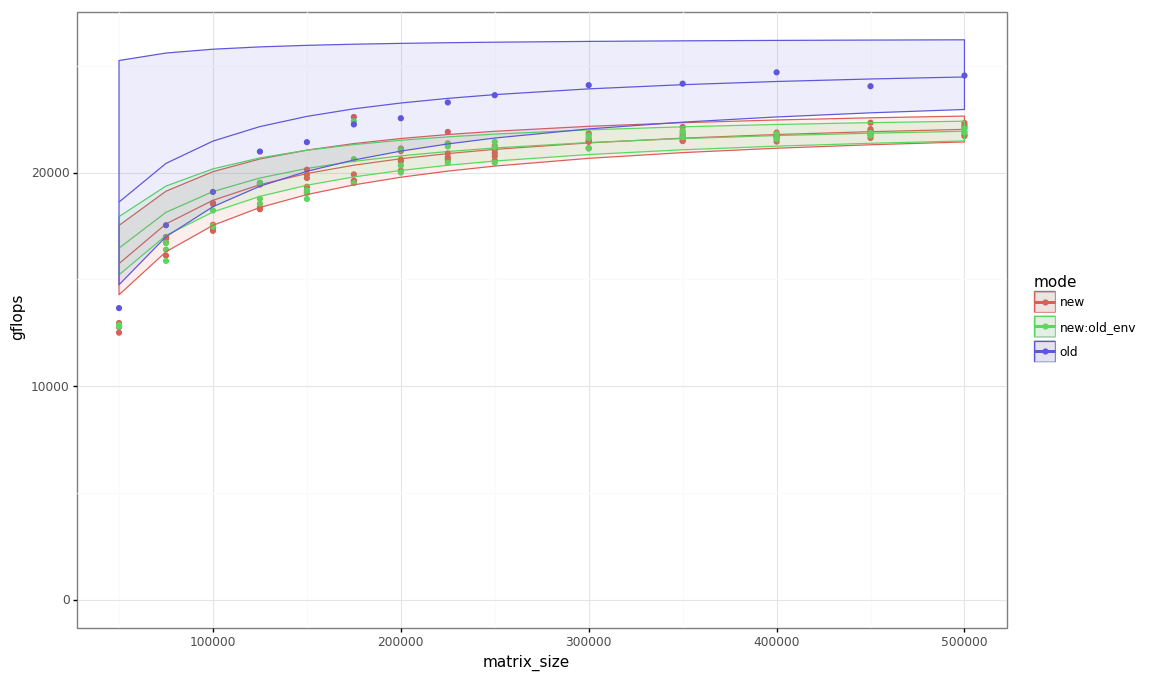

<ggplot: (8792400046305)>

In [11]:
plot = ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + geom_line(aes(x='matrix_size', y='pred_gflops')) + geom_point() + theme_bw() + expand_limits(y=0)
plot + geom_ribbon(aes(ymin='pred_gflops_min', ymax='pred_gflops_max', fill='mode'), alpha=0.1)

### Pretty plot for the slides

In [12]:
df['date'] = '2019/03'
df.loc[df['mode'] == 'old', 'date'] = '2018/10'
df = df[(df['mode'] == 'old') | (df['index'] > 0)]  # removing the first execution of the recent experiment

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 8 in image.
  from_inches(height, units), units))
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /tmp/hpl_old_perf.pdf
  warn('Filename: {}'.format(filename))


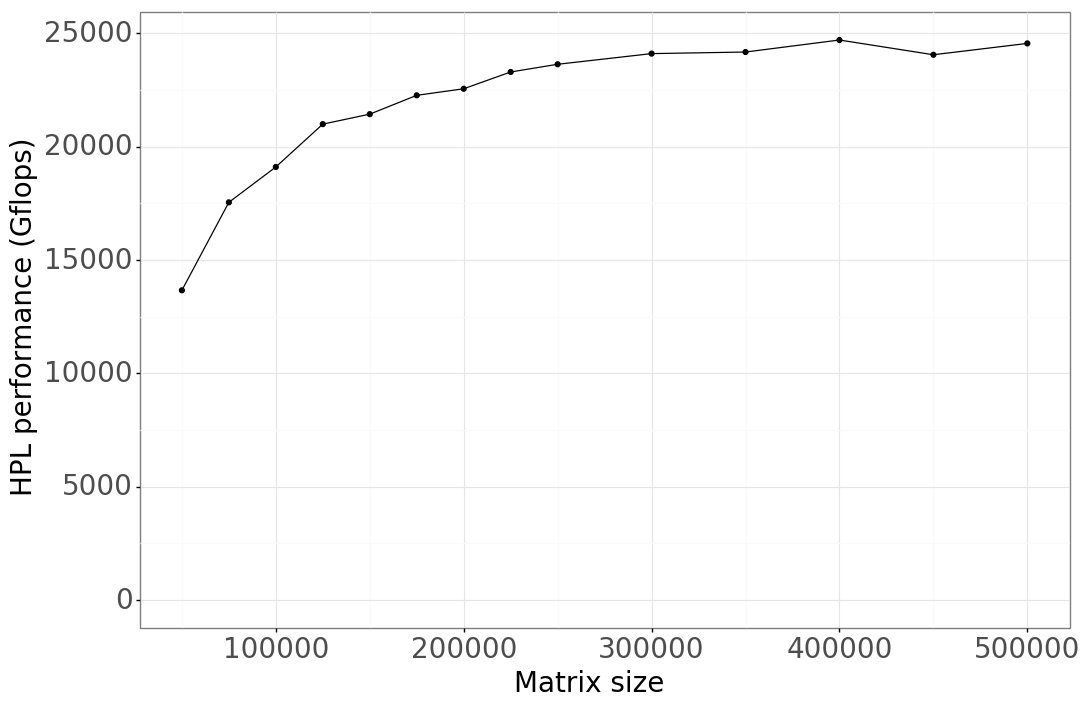

<ggplot: (-9223363244454801678)>

In [13]:
def plot_style(plot, font_size=20):
    plot = plot + theme_bw() + expand_limits(y=0) + xlab('Matrix size') + ylab('HPL performance (Gflops)')
    plot = plot + theme(text = element_text(size=font_size))
    return plot

plot = plot_style(ggplot(df[df['mode'] == 'old'], aes(x='matrix_size', y='gflops')))
plot = plot + stat_summary(fun_y = numpy.mean, geom='line') + geom_point()
plot.save('/tmp/hpl_old_perf.pdf')
plot

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 8 in image.
  from_inches(height, units), units))
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /tmp/hpl_new_perf.pdf
  warn('Filename: {}'.format(filename))


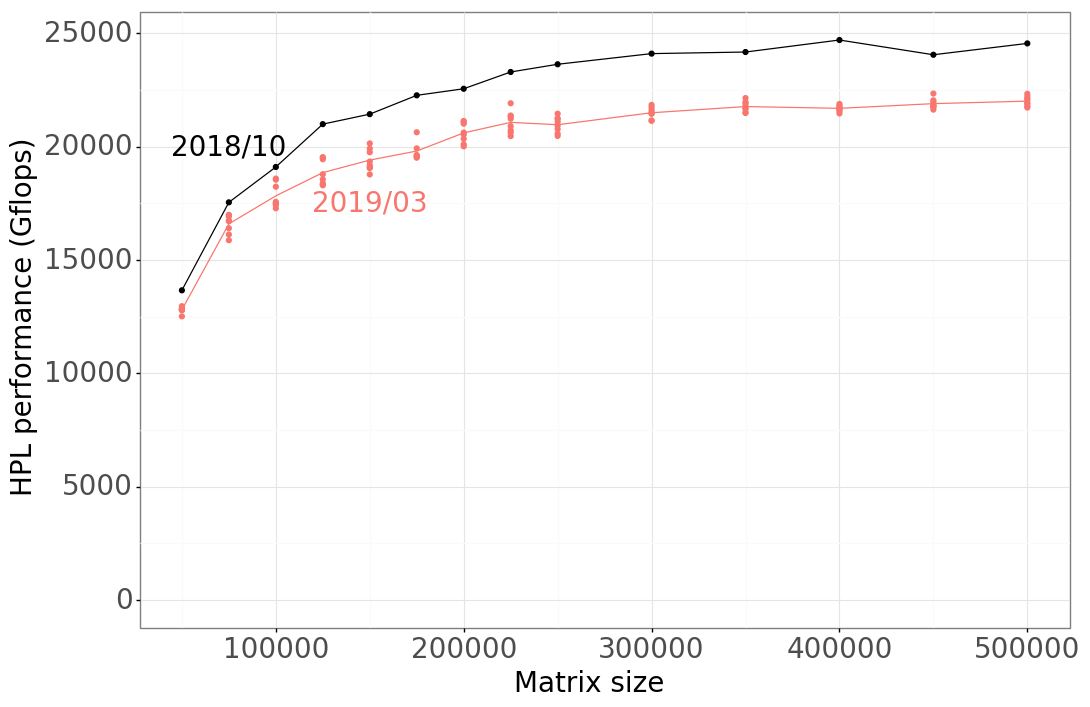

<ggplot: (-9223363244454826545)>

In [14]:
plot = plot_style(ggplot(aes(x='matrix_size', y='gflops')))
plot = plot + stat_summary(df[df['mode'] == 'old'], fun_y = numpy.mean, geom='line') + geom_point(df[df['mode'] == 'old'])
plot = plot + stat_summary(df[df['mode'] != 'old'], fun_y = numpy.mean, geom='line', color='#F8766D') + geom_point(df[df['mode'] != 'old'], color='#F8766D')
plot = plot + annotate(geom='text', label='2018/10', x=75000, y=20000, size=20)
plot = plot + annotate(geom='text', label='2019/03', x=150000, y=17500, size=20, color='#F8766D')
plot.save('/tmp/hpl_new_perf.pdf')
plot